In [ ]:
# Core
import os
import glob

# Data / numeric
import numpy as np
import pandas as pd

# Audio
import librosa
import librosa.display

# ML
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Plotting
import matplotlib.pyplot as plt

# Save model
import joblib

# General config
DATA_DIR = "../data/RAVDESS"
SR = 16_000        # target sampling rate, also a standard for audio ML, lighter computation, enough for speech
N_MFCC = 13        # MFCC coefficients


In [38]:
# Get all wav file paths
wav_files = glob.glob(os.path.join(DATA_DIR, "**", "*.wav"), recursive=True)
len(wav_files)


2880

In [24]:
emotion_map = {
    "01": "neutral",
    "02": "calm",
    "03": "happy",
    "04": "sad",
    "05": "angry",
    "06": "fearful",
    "07": "disgust",
    "08": "surprised",
}

def parse_ravdess_filename(path):
    """Return dict with emotion_id, emotion_label, actor_id, gender."""
    fname = os.path.basename(path)        # e.g. '03-01-05-01-02-02-12.wav'
    parts = fname.split('.')[0].split('-')
    
    emotion_id = parts[2]                 # 3rd element
    emotion_label = emotion_map.get(emotion_id, "unknown")
    
    actor_id = int(parts[-1])             # last element
    gender = "male" if actor_id % 2 == 1 else "female"
    
    return {
        "filepath": path,
        "emotion_id": emotion_id,
        "emotion": emotion_label,
        "actor_id": actor_id,
        "gender": gender,
    }

rows = [parse_ravdess_filename(p) for p in wav_files]
df = pd.DataFrame(rows)
df.head()


,filepath,emotion_id,emotion,actor_id,gender
0,../data/RAVDESS\Actor_01\03-01-01-01-01-01-01.wav,01,neutral,1,male
1,../data/RAVDESS\Actor_01\03-01-01-01-01-02-01.wav,01,neutral,1,male
2,../data/RAVDESS\Actor_01\03-01-01-01-02-01-01.wav,01,neutral,1,male
3,../data/RAVDESS\Actor_01\03-01-01-01-02-02-01.wav,01,neutral,1,male
4,../data/RAVDESS\Actor_01\03-01-02-01-01-01-01.wav,02,calm,1,male


In [25]:
df["emotion"].value_counts()


emotion
calm         384
happy        384
sad          384
angry        384
disgust      384
fearful      384
surprised    384
neutral      192
Name: count, dtype: int64

In [ ]:
def load_and_preprocess(path, sr=SR):
    #sr = 16000, resamples to the target sampling rate, mono = converts stereo to mono
    y, _ = librosa.load(path, sr=sr, mono=True) 
    
    # Trim leading & trailing silence
    y, _ = librosa.effects.trim(y, top_db=25) # top_db=25 means segments that are more than 25 dB below the peak are considered silence
    
    # Normalize to unit peak
    y = librosa.util.normalize(y)
    return y


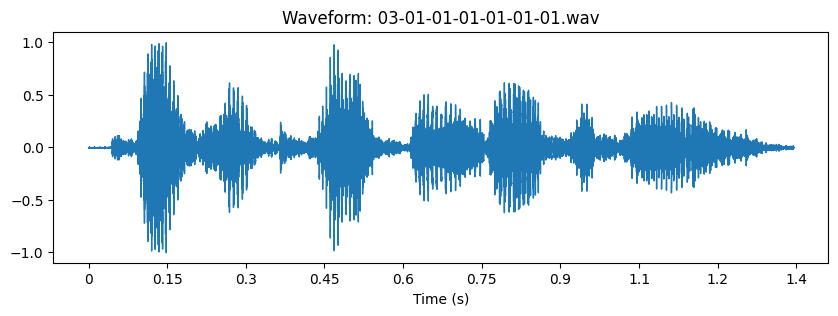

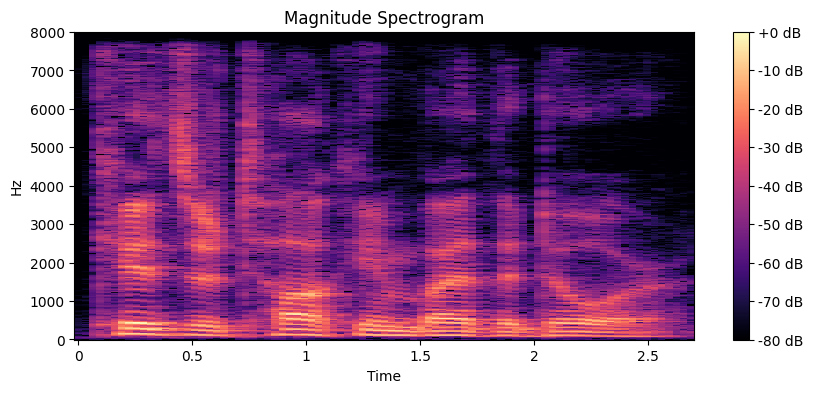

In [27]:
example_path = df.iloc[0]["filepath"]
y = load_and_preprocess(example_path)

plt.figure(figsize=(10, 3))
librosa.display.waveshow(y, sr=SR)
plt.title(f"Waveform: {os.path.basename(example_path)}")
plt.xlabel("Time (s)")
plt.show()

# Spectrogram
D = np.abs(librosa.stft(y, n_fft=1024, hop_length=256))
DB = librosa.amplitude_to_db(D, ref=np.max)

plt.figure(figsize=(10, 4))
librosa.display.specshow(DB, sr=SR, x_axis="time", y_axis="hz")
plt.colorbar(format="%+2.0f dB")
plt.title("Magnitude Spectrogram")
plt.show()


In [28]:
def extract_features(y, sr=SR, n_mfcc=N_MFCC):
    # MFCCs
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_delta = librosa.feature.delta(mfcc)
    
    # ZCR (time-domain)
    zcr = librosa.feature.zero_crossing_rate(y)
    
    # Spectral features
    centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    
    # Aggregate with mean and std over time
    features = np.concatenate([
        mfcc.mean(axis=1), mfcc.std(axis=1),
        mfcc_delta.mean(axis=1), mfcc_delta.std(axis=1),
        zcr.mean(axis=1), zcr.std(axis=1),
        centroid.mean(axis=1), centroid.std(axis=1),
        bandwidth.mean(axis=1), bandwidth.std(axis=1),
    ])
    
    return features


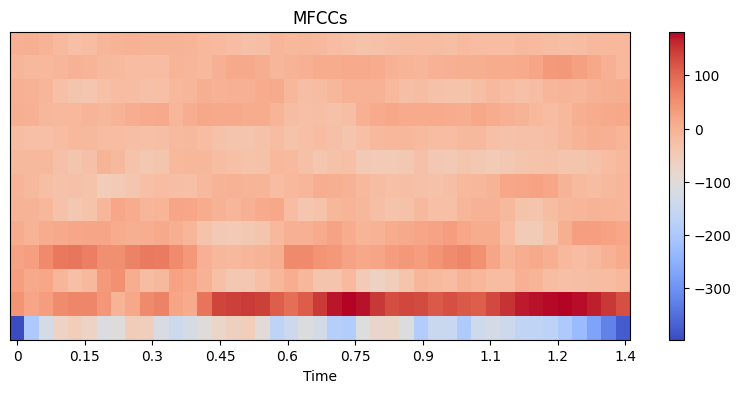

In [30]:
example_path = df.iloc[0]["filepath"]
y = load_and_preprocess(example_path)

mfcc = librosa.feature.mfcc(y=y, sr=SR, n_mfcc=13)


plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis="time", sr=SR)
plt.colorbar()
plt.title("MFCCs")
plt.show()


In [31]:
X_list = []
y_list = []

for i, row in df.iterrows():
    y_signal = load_and_preprocess(row["filepath"])
    feats = extract_features(y_signal, sr=SR)
    
    X_list.append(feats)
    y_list.append(row["emotion"])      # string label

X = np.vstack(X_list)
y = np.array(y_list)

X.shape, y.shape


((2880, 58), (2880,))

In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

svm_clf = SVC(kernel="rbf", probability=True, random_state=42)

svm_clf.fit(X_train_scaled, y_train)


,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,True
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


              precision    recall  f1-score   support

       angry       0.89      0.92      0.90        76
        calm       0.82      0.92      0.87        77
     disgust       0.85      0.88      0.87        77
     fearful       0.84      0.74      0.79        77
       happy       0.91      0.81      0.86        77
     neutral       0.82      0.84      0.83        38
         sad       0.78      0.82      0.80        77
   surprised       0.92      0.88      0.90        77

    accuracy                           0.85       576
   macro avg       0.85      0.85      0.85       576
weighted avg       0.85      0.85      0.85       576



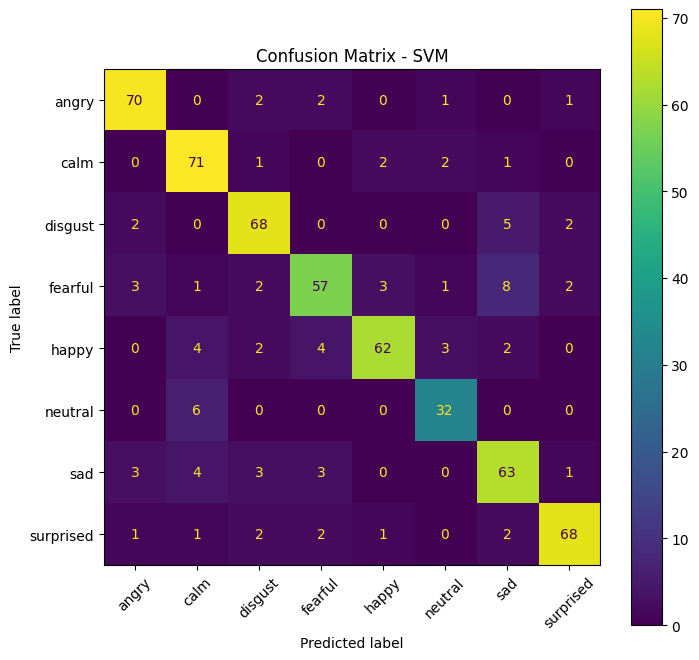

In [33]:
y_pred = svm_clf.predict(X_test_scaled)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred, labels=sorted(np.unique(y)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=sorted(np.unique(y)))
fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(ax=ax, xticks_rotation=45)
plt.title("Confusion Matrix - SVM")
plt.show()


In [34]:
os.makedirs("../models", exist_ok=True)

joblib.dump(scaler, "../models/scaler.joblib")
joblib.dump(svm_clf, "../models/svm_ravdess.joblib")
print("Models saved to ../models/")

Models saved to ../models/


In [35]:
def predict_emotion_from_signal(signal, sr=SR):
    """signal: 1D numpy array (float), already raw audio."""
    y_proc = librosa.util.normalize(signal)
    feats = extract_features(y_proc, sr=sr)
    feats_scaled = scaler.transform(feats.reshape(1, -1))
    
    pred_label = svm_clf.predict(feats_scaled)[0]
    pred_proba = svm_clf.predict_proba(feats_scaled)[0]
    
    return pred_label, pred_proba


In [ ]:
# Test on a random sample from the dataset

test_path = df.sample(1, random_state=0)["filepath"].iloc[0]
test_signal = load_and_preprocess(test_path)

label, proba = predict_emotion_from_signal(test_signal)
label


np.str_('angry')